In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from src.configuration.constants import PROCESSED_DATA_DIRECTORY, ROOT_DIRECTORY, INTERIM_DATA_DIRECTORY
from src.processor import AnomalyDataset

import logging
import random
import numpy as np
import pickle
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint


import matplotlib.pyplot as plt

import tensorflow as tf
from functools import partial
from mlprimitives import load_primitive

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from orion.evaluation.contextual import contextual_f1_score, contextual_confusion_matrix
import pandas as pd
import random


from mlprimitives import load_primitive

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/

# Phase 0: Prepare dataset

In [2]:
source = 'NASA'
dataset = 'MSL'
signal = 'T-8'

anomaly_dataset = AnomalyDataset.load(source, dataset, signal)

In [3]:
X_train, y_train, labels_train, index_train = anomaly_dataset.train.X_processed, anomaly_dataset.train.y_processed, anomaly_dataset.train.labels_processed, anomaly_dataset.train.index
X_train.shape, y_train.shape, labels_train.shape, index_train.shape

((648, 100, 55), (648, 100, 1), (648,), (748,))

In [4]:
X_test, y_test, labels_test, index_test, anomalies_test = anomaly_dataset.test.X_processed, anomaly_dataset.test.y_processed, anomaly_dataset.test.labels_processed, anomaly_dataset.test.index, anomaly_dataset.test.anomalies
X_test.shape, y_test.shape, labels_test.shape, index_test.shape

((1419, 100, 55), (1419, 100, 1), (1419,), (1519,))

# Phase 1: Semi-supervised GAN

## Discriminator

### Separate Discriminator Models With Shared Weights


#### Encoder

In [5]:
def build_encoder(input_shape, lstm_units, dense_units, encoder_reshape_shape):
    x = Input(shape=input_shape)
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))
    model.add(Flatten())
    model.add(Dense(units=dense_units))
    model.add(Reshape(target_shape=encoder_reshape_shape))
    return Model(x, model(x))

#### Generator

In [6]:
def build_generator(input_shape, generator_reshape_dim, generator_reshape_shape):
    x = Input(shape=input_shape)
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=generator_reshape_dim))
    model.add(Reshape(target_shape=generator_reshape_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'))
    model.add(UpSampling1D(size=2))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'))
    model.add(TimeDistributed(Dense(units=1)))
    model.add(Activation(activation='tanh'))
    return Model(x, model(x))
              

#### Critic X

In [7]:
def build_critic_x(input_shape, n_classes):
    x = Input(shape=input_shape)
    model = Sequential()
    
    for _ in range(4):
        model.add(Conv1D(filters=64, kernel_size=5))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    
    # Unsupervised model
    unsup_out = Dense(units=1)(model(x))
    d_unsup_model = Model(x, unsup_out)
    
    # Supervised model
    sup_out = Dense(units=n_classes, activation='softmax')(model(x))
    d_sup_model = Model(x, sup_out)
    
    return d_unsup_model, d_sup_model

#### Critic Z

In [8]:
def build_critic_z(input_shape, dense_units=20):
    x = Input(shape=input_shape)
    model = Sequential()
    model.add(Flatten())
    
    for _ in range(2):
        model.add(Dense(units=dense_units))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(rate=0.2))
        
    model.add(Dense(units=1))
    return Model(x, model(x))

#### Hyper-parameters

In [9]:
input_shape=X_test[0].shape
target_shape=y_test[0].shape
latent_dim=20
learning_rate=0.0005
epochs=70
batch_size=64
iterations_critic=5
latent_shape = (latent_dim, 1)
n_classes = 2

shape = np.asarray(X_test)[0].shape
length = shape[0]
target_shape = np.asarray(y_test)[0].shape


generator_reshape_dim = length // 2
generator_reshape_shape = (length // 2, 1)
encoder_reshape_shape = latent_shape

encoder_input_shape = shape
generator_input_shape = latent_shape
critic_x_input_shape = target_shape
critic_z_input_shape = latent_shape

lstm_units = 100
dense_units = 20

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [10]:
encoder = build_encoder(
    input_shape=encoder_input_shape,
    lstm_units=lstm_units,
    dense_units=dense_units,
    encoder_reshape_shape=encoder_reshape_shape,
)

generator = build_generator(
    input_shape=generator_input_shape,
    generator_reshape_dim=generator_reshape_dim,
    generator_reshape_shape=generator_reshape_shape,
)

critic_x_unsup, critic_x_sup = build_critic_x(
    input_shape=critic_x_input_shape,
    n_classes=n_classes
)

critic_z = build_critic_z(
    input_shape=critic_z_input_shape,
)

In [11]:
def _wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def _gradient_penalty_loss(y_true, y_pred, averaged_samples):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)

class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        alpha = K.random_uniform((self.batch_size, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [12]:
generator.trainable = False
encoder.trainable = False

x = Input(shape=input_shape)
y = Input(shape=target_shape)
z = Input(shape=(latent_dim, 1))

x_ = generator(z)
z_ = encoder(x)
fake_x = critic_x_unsup(x_) # Fake
valid_x = critic_x_unsup(y) # Truth

label = critic_x_sup(y)

#### Critic X Unsupervised Model

In [13]:
interpolated_x = RandomWeightedAverage(batch_size)([y, x_])
validity_interpolated_x = critic_x_unsup(interpolated_x)
partial_gp_loss_x = partial(_gradient_penalty_loss, averaged_samples=interpolated_x)
partial_gp_loss_x.__name__ = 'gradient_penalty'
critic_x_unsup_model = Model(inputs=[y, z], outputs=[valid_x, fake_x,validity_interpolated_x])
critic_x_unsup_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, partial_gp_loss_x], 
                       optimizer=optimizer, loss_weights=[1, 1, 10])
critic_x_unsup_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 100, 1)       133787      input_7[0][0]                    
__________________________________________________________________________________________________
random_weighted_average (Random (64, 100, 1)         0           input_6[0][0]                    
                                                                 model_1[1][0]              

#### Critic X Supervised Model

In [14]:
critic_x_sup.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy'], # 'f1', 'precision', 'recall'
)
critic_x_sup_model = critic_x_sup
critic_x_sup_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
sequential_2 (Sequential)    multiple                  62016     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10754     
Total params: 72,770
Trainable params: 72,770
Non-trainable params: 0
_________________________________________________________________


#### Critic Z Model

In [15]:
fake_z = critic_z(z_)
valid_z = critic_z(z)
interpolated_z = RandomWeightedAverage()([z, z_])
validity_interpolated_z = critic_z(interpolated_z)
partial_gp_loss_z = partial(_gradient_penalty_loss, averaged_samples=interpolated_z)
partial_gp_loss_z.__name__ = 'gradient_penalty'
critic_z_model = tf.keras.Model(inputs=[x, z], outputs=[valid_z, fake_z,validity_interpolated_z])
critic_z_model.compile(loss=[_wasserstein_loss, _wasserstein_loss,
                                  partial_gp_loss_z], optimizer=optimizer,
                            loss_weights=[1, 1, 10])
critic_z_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 55)]    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 20, 1)        524820      input_5[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_1 (Rand (64, 20, 1)          0           input_7[0][0]                    
                                                                 model[1][0]                

#### Encoder Generator Model

In [16]:
critic_x_sup.trainable = False
critic_x_unsup.trainable = False
critic_z.trainable = False
generator.trainable = True
encoder.trainable = True

z_gen = Input(shape=(latent_dim, 1))
x_gen_ = generator(z_gen)
x_gen = Input(shape=input_shape)
z_gen_ = encoder(x_gen)
x_gen_rec = generator(z_gen_)
fake_gen_x = critic_x_unsup(x_gen_)
fake_gen_z = critic_z(z_gen_)

encoder_generator_model = Model([x_gen, z_gen], [fake_gen_x, fake_gen_z, x_gen_rec])
encoder_generator_model.compile(loss=[_wasserstein_loss, _wasserstein_loss,'mse'], 
                                optimizer=optimizer,
                                loss_weights=[1, 1, 10])

encoder_generator_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100, 55)]    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 100, 1)       133787      input_8[0][0]                    
                                                                 model[2][0]                      
__________________________________________________________________________________________________
model (Model)                   (None, 20, 1)        524820      input_9[0][0]              

## Dataset Selection

In [17]:
def split_supervised_samples(X, y, labels, limit=None):
    labels = pd.Series(labels)
    
    sup_anomaly_index = labels[labels==1].index
    if limit is not None:
        sup_anomaly_index = random.choices(sup_anomaly_index, k=limit)
        
    sup_anomaly_samples = y[sup_anomaly_index]
    num_anomaly_samples = len(sup_anomaly_samples)
    
    sup_non_anomaly_index = random.choices(labels[labels==0].index,  k=num_anomaly_samples)
    sup_non_anomaly_samples = y[sup_non_anomaly_index]
    
    sup_samples = np.concatenate((sup_anomaly_samples, sup_non_anomaly_samples))
    sup_labels = np.concatenate((np.ones(len(sup_anomaly_samples)), np.zeros(len(sup_non_anomaly_samples))))
    
    X_unsup = X[~np.isin(np.arange(len(X)), list(sup_anomaly_index) + list(sup_non_anomaly_index))]
    y_unsup = y[~np.isin(np.arange(len(y)), list(sup_anomaly_index) + list(sup_non_anomaly_index))]
    
    return sup_samples, sup_labels, X_unsup, y_unsup

In [18]:
def select_supervised_samples(n_samples, X, labels, n_classes):
    """Select a supervised subset of the dataset, ensures classes are balanced."""
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
        X_with_class = X[labels == i]
        ix = randint(0, len(X_with_class), n_per_class)
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    return asarray(X_list), asarray(y_list)

def generate_real_samples(n_samples, X, labels):
    """Randomly select real samples."""
    ix = randint(0, X.shape[0], n_samples)
    X, labels = X[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y

def generate_latent_points(n_samples, latent_dim):
    """Generate points in latent space as input for the generator."""
    return np.random.normal(size=(n_samples, latent_dim, 1))
 
def generate_fake_samples(n_samples, latent_dim, generator):
    """Generate n fake examples with class labels."""
    z = generate_latent_points(n_samples, latent_dim)
    x_ = generator(z)
    y = zeros((n_samples, 1))
    return x_, y

## Training

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
enable_supervised = True
num_samples = 100

fake = np.ones((batch_size, 1))
valid = -np.ones((batch_size, 1))
delta = np.ones((batch_size, 1))

X_sup, labels_sup, X_unsup, y_unsup = split_supervised_samples(X_test, y_test, labels_test, num_samples)
X_sup_train, X_sup_val, labels_sup_train, labels_sup_val = train_test_split(X_sup, labels_sup, stratify=labels_sup)

X_sup_train.shape, X_sup_val.shape, labels_sup_train.shape, labels_sup_val.shape, X_unsup.shape, y_unsup.shape

((150, 100, 1), (50, 100, 1), (150,), (50,), (1242, 100, 55), (1242, 100, 1))

In [21]:
epoch_loss = []
indices = np.arange(X_train.shape[0])
for epoch in range(1, epochs + 1):
    np.random.shuffle(indices)
    X_ = X_train[indices]
    y_ = y_train[indices]

    epoch_g_loss = []
    epoch_cx_loss = []
    epoch_cx_sup_loss = []
    epoch_cz_loss = []

    minibatches_size = batch_size * iterations_critic
    num_minibatches = int(X_.shape[0] // minibatches_size)
    
    if enable_supervised:
        # [X_sup_real, y_sup_real], _ = generate_real_samples(2 * num_samples, X_sup_train, labels_sup_train)
        
        sup_loss = critic_x_sup_model.train_on_batch(X_sup_train, labels_sup_train)
        sup_val = critic_x_sup_model.test_on_batch(X_sup_val, labels_sup_val)
        epoch_cx_sup_loss.append(
            list(sup_loss) + list(sup_val)
        )

    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
        y_minibatch = y_[i * minibatches_size: (i + 1) * minibatches_size]
    

        for j in range(iterations_critic):
            x = minibatch[j * batch_size: (j + 1) * batch_size]
            y = y_minibatch[j * batch_size: (j + 1) * batch_size]
            z = np.random.normal(size=(batch_size, latent_dim, 1))
            
            epoch_cx_loss.append(
                critic_x_unsup_model.train_on_batch([y, z], [valid, fake, delta]))
            epoch_cz_loss.append(
                critic_z_model.train_on_batch([x, z], [valid, fake, delta]))

        epoch_g_loss.append(
            encoder_generator_model.train_on_batch([x, z], [valid, valid, y]))

    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cx_sup_loss = np.mean(np.array(epoch_cx_sup_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    epoch_loss.append([cx_loss, cx_sup_loss, cz_loss, g_loss])
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dx_sup loss: {}] [Dz loss: {}] [G loss: {}]'.format(
        epoch, epochs, cx_loss, cx_sup_loss, cz_loss, g_loss))

2022-02-01 20:14:20.902997: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-02-01 20:14:20.940025: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe8c5f9ad00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-01 20:14:20.940052: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch: 1/70, [Dx loss: [ 4.650427   -1.0975657   0.00884674  0.5739145 ]] [Dx_sup loss: [0.7028777  0.46       0.69511384 0.58      ]] [Dz loss: [ 1.3810084  -0.22445467  0.1618574   0.14436057]] [G loss: [ 9.756422   -0.02321387 -0.16450466  0.9944141 ]]
Epoch: 2/70, [Dx loss: [ -7.4670057  -12.656346     0.27028742   0.4919053 ]] [Dx_sup loss: [0.679976  0.56      0.6956872 0.5      ]] [Dz loss: [ 1.9917488  -0.32771677  1.301069    0.10183966]] [G loss: [ 8.065378   -0.16127142 -1.3607268   0.9587377 ]]
Epoch: 3/70, [Dx loss: [-8.658025   -9.633446    0.3295616   0.06458577]] [Dx_sup loss: [0.7000648  0.5466667  0.71395713 0.5       ]] [Dz loss: [ 3.7536473  -0.39904037  3.3740895   0.0778598 ]] [G loss: [ 5.2938037  -0.3153779  -2.8623843   0.84715664]]
Epoch: 4/70, [Dx loss: [ -9.001259   -12.843104     1.0086093    0.28332362]] [Dx_sup loss: [0.73102784 0.52       0.7001117  0.5       ]] [Dz loss: [ 4.876334   -0.3132231   4.3550477   0.08345097]] [G loss: [ 1.883879  -0.9834337 

In [23]:
def plot_losses(tadgan_loss, output_directory=None):
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharey=False, sharex=True)

    epoch_loss_names = [
        ['valid_x_wasserstein_loss', 'fake_x_wasserstein_loss', 'partial_gp_loss_x', 'weighted_loss'],
        ['train_sparse_categorical_crossentropy_loss', 'train_accuracy', 'val_sparse_categorical_crossentropy_loss', 'val_accuracy'],
        ['valid_z_wasserstein_loss', 'fake_z_wasserstein_loss', 'partial_gp_loss_z', 'weighted_loss'],
        ['fake_gen_x_wasserstein_loss', 'fake_gen_z_wasserstein_loss', 'mse', 'weighted_loss'],
    ]
    
    num_epoch, num_model, num_loss = tadgan_loss.shape

    index = [epoch for epoch in range(num_epoch)]
    for i in range(num_model):
        for j in range(num_loss):
            axs[i][j].set_title(epoch_loss_names[i][j])
            axs[i][j].plot(index, tadgan_loss[:, i, j], label='tadgan', color='b')

    fig.suptitle(f'[{source}] [{dataset}] [{signal}] Epoch losses', fontsize=16)
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    # fig.savefig(os.path.join(output_directory, 'epoch_losses.png'))

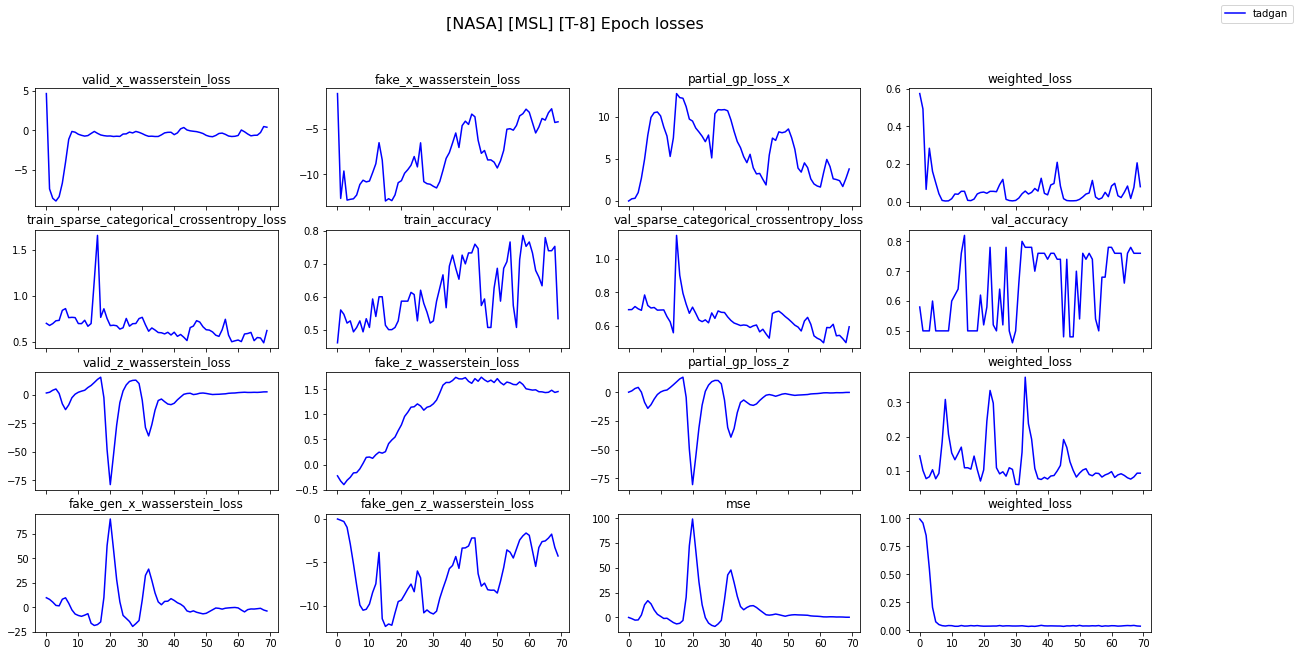

In [24]:
plot_losses(np.array(epoch_loss))

## Evaluation of unsupervised model

In [25]:
z_ = encoder.predict(X_test)
y_hat = generator.predict(z_)
critic = critic_x_unsup.predict(y_test)

z_.shape, y_hat.shape, critic.shape

((1419, 20, 1), (1419, 100, 1), (1419, 1))

In [26]:
params = {"rec_error_type": "dtw", "comb": "mult"}

primitive = load_primitive("orion.primitives.tadgan.score_anomalies", 
                           arguments=params)
errors, true_index, true, predictions = primitive.produce(y=y_test, y_hat=y_hat, critic=critic, index=index_test)

Using TensorFlow backend.


In [27]:
params = {
"window_size_portion": 0.33, 
"window_step_size_portion": 0.1,
"fixed_threshold": True
}

primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                           arguments=params)
predicted_anomalies = primitive.produce(errors=errors, index=true_index)
predicted_anomalies = [(int(anomaly[0]), int(anomaly[1])) for anomaly in predicted_anomalies]

In [28]:
confusion_matrix = contextual_confusion_matrix(
    anomalies_test, 
    predicted_anomalies, 
    start=list(index_test)[0], 
    end=list(index_test)[-1], 
    weighted=False
)
confusion_matrix

(None, 3, 1, 1)

# Phase 2: Query Strategies

In [193]:
# What did the unsupervised GAN say was an anomaly?
z_ = encoder.predict(X_train)
y_hat = generator.predict(z_)
critic = critic_x_unsup.predict(y_train)

params = {"rec_error_type": "dtw"}

primitive = load_primitive("orion.primitives.tadgan.score_anomalies", arguments=params)
errors, true_index, true, predictions = primitive.produce(y=y_train, y_hat=y_hat, critic=critic, index=index_train)

params = {
    "window_size_portion": 0.05, 
    "window_step_size_portion": 0.1,
    "fixed_threshold": True
}

primitive = load_primitive("orion.primitives.timeseries_anomalies.find_anomalies", 
                           arguments=params)
e = primitive.produce(errors=errors, index=true_index)

anomalies = [(int(i[0]), int(i[1])) for i in e]
pp_samples = []

for s, e in anomalies:
    for i in range(s, e):
        pp_samples.append(X_sup[i])

In [200]:
pp_samples = pd.Series(pp_samples)
pp_samples.shape

(0,)

In [188]:
# What did the supervised GAN get wrong?
X_sup, labels_sup
labels_sup = pd.Series(labels_sup)

sup_predictions = critic_x_sup_model.predict(X_sup)

idx = np.argmax(sup_predictions, axis=-1)
sup_predictions = np.zeros( sup_predictions.shape )
sup_predictions[ np.arange(sup_predictions.shape[0]), idx] = 1
sup_predictions = [list(i).index(1.0) for i in sup_predictions]
sup_predictions = pd.Series(sup_predictions)

# False Positives
fp = X_sup[(sup_predictions == 1) & (labels_sup == 0)]
fn = X_sup[(sup_predictions == 0) & (labels_sup == 1)]


In [196]:
fp

array([], shape=(0, 100, 1), dtype=float64)

In [189]:
# How should we explore datasets?

exploration = X_train[np.random.choice([i for i in range(len(X_train))], 20)]

In [201]:
annotation_set = [
    # pp_samples,
    fp,
    fn,
    exploration
]
annotation_set = np.concatenate(annotation_set)
annotation_set.shape

(26, 100, 1)

# Phase 3: Annotation Strategy

In [204]:
# How do we combine labels from different people?

labels = labels_train(annotation_set.index)

AttributeError: 'numpy.ndarray' object has no attribute 'index'